In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns



# Load the dataset
data = pd.read_csv("Electric_cars_dataset.csv")

In [102]:
data.head()

,ID,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,Expected Price ($1k)
0,EV33174,5YJ3E1EC6L,Snohomish,LYNNWOOD,WA,98037.0,2020.0,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,32.0,109821694,POINT (-122.287614 47.83874),PUGET SOUND ENERGY INC,50
1,EV40247,JN1AZ0CP8B,Skagit,BELLINGHAM,WA,98229.0,2011.0,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,40.0,137375528,POINT (-122.414936 48.709388),PUGET SOUND ENERGY INC,15
2,EV12248,WBY1Z2C56F,Pierce,TACOMA,WA,98422.0,2015.0,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,0,27.0,150627382,POINT (-122.396286 47.293138),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,18
3,EV55713,1G1RD6E44D,King,REDMOND,WA,98053.0,2013.0,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,38,0,45.0,258766301,POINT (-122.024951 47.670286),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),33.9
4,EV28799,1G1FY6S05K,Pierce,PUYALLUP,WA,98375.0,2019.0,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,25.0,296998138,POINT (-122.321062 47.103797),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,41.78


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64353 entries, 0 to 64352
Data columns (total 18 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 64353 non-null  object 
 1   VIN (1-10)                                         64353 non-null  object 
 2   County                                             64349 non-null  object 
 3   City                                               64344 non-null  object 
 4   State                                              64342 non-null  object 
 5   ZIP Code                                           64347 non-null  float64
 6   Model Year                                         64346 non-null  float64
 7   Make                                               64349 non-null  object 
 8   Model                                              64340 non-null  object 
 9   Electr

In [22]:
data.isnull().sum()

County                                                 4
City                                                   9
State                                                 11
ZIP Code                                               0
Model Year                                             0
Make                                                   4
Model                                                 13
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                   0
Vehicle Location                                     510
Electric Utility                                     722
Expected Price ($1k)                                   0
dtype: int64

Now as we can see it, we cannot use the dataset as it is right now to start building our SVM model.
First of all we have to drop the features in the dataset that we don't need to build the model; features like: 'ID', 'VIN (1-10)' and 'DOL Vehicle ID'.
These features are dropped because they don't ccontribute meaningful information to the prediction task.Including them can add noise and complexity to the model without providing any real benefit.
Secondly, we'll have to handle Missing and corrupted values and depending on the nature of the variable (categorical or numerical), we'll either use the mode or the mean.
After that, we'll encode the categorical features and finally, we'll remove duplicates if they exist.
Note that we didn't talk about handling outliers because SVM algorithm has a feature to ignore outliers.

In [2]:
# Drop useless features
useless_features = ['ID', 'VIN (1-10)', 'DOL Vehicle ID']
data = data.drop(useless_features, axis=1)

In [3]:
# List of categorical columns with missing values
categorical_columns = ['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Vehicle Location', 'Electric Utility', 'Expected Price ($1k)']

# List of numerical columns with missing values
numerical_columns = ['ZIP Code', 'Model Year', 'Legislative District']

# Replace numerical missing values with the mean
for col in numerical_columns:
    data[col].fillna(data[col].mean(), inplace=True)
    
# Replace categorical missing values with the mode
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [4]:
# List of categorical columns for one-hot encoding
categorical_columns = ['County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Vehicle Location', 'Electric Utility']

# Extract the categorical columns from the DataFrame
data_categorical = data[categorical_columns]

# Create a OneHotEncoder instance
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity

# Fit and transform the categorical columns
onehot_encoded = onehot_encoder.fit_transform(data_categorical)

# Create a DataFrame with the one-hot encoded features
onehot_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded features with the original DataFrame
data_encoded = pd.concat([data, onehot_df], axis=1)

# Drop the original categorical columns if needed
data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Now 'data_encoded' contains the original data with one-hot encoded categorical columns
#data_encoded

In [5]:
# Define the target variable for encoding
target_variable_to_encode = ['Expected Price ($1k)']

# Create a label encoder
label_encoder = LabelEncoder()

# Fit and transform the specified column
data_encoded[target_variable_to_encode + '_encoded'] = label_encoder.fit_transform(data_encoded[target_variable_to_encode])

#data_encoded

In [92]:
# Handling duplicates
duplicates = data_encoded[data_encoded.duplicated()]
duplicates

,ZIP Code,Model Year,Electric Range,Base MSRP,Legislative District,Expected Price ($1k),County_Alameda,County_Albemarle,County_Alexandria City,County_Allegheny,...,Electric Utility_PORTLAND GENERAL ELECTRIC CO,Electric Utility_PUD NO 1 OF CHELAN COUNTY,Electric Utility_PUD NO 1 OF DOUGLAS COUNTY,Electric Utility_PUD NO 1 OF OKANOGAN COUNTY,Electric Utility_PUD NO 1 OF PEND OREILLE COUNTY,Electric Utility_PUD NO 1 OF WHATCOM COUNTY,Electric Utility_PUD NO 2 OF GRANT COUNTY,Electric Utility_PUGET SOUND ENERGY INC,Electric Utility_PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),Electric Utility_PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM COUNTY
247,98006.0,2017.0,200,0,41.0,176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
384,98117.0,2020.0,322,0,36.0,154,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395,98052.0,2022.0,0,0,48.0,175,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
448,98077.0,2019.0,220,0,45.0,164,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
474,98115.0,2021.0,0,0,46.0,188,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64345,98144.0,2022.0,0,0,37.0,175,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64346,98116.0,2022.0,0,0,34.0,206,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64347,98370.0,2013.0,75,0,23.0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64348,98144.0,2020.0,239,0,37.0,110,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data_encoded = data_encoded.drop_duplicates()
duplicates = data_encoded[data_encoded.duplicated()]
#duplicates

In [94]:
data_encoded.head()

,ZIP Code,Model Year,Electric Range,Base MSRP,Legislative District,Expected Price ($1k),County_Alameda,County_Albemarle,County_Alexandria City,County_Allegheny,...,Electric Utility_PORTLAND GENERAL ELECTRIC CO,Electric Utility_PUD NO 1 OF CHELAN COUNTY,Electric Utility_PUD NO 1 OF DOUGLAS COUNTY,Electric Utility_PUD NO 1 OF OKANOGAN COUNTY,Electric Utility_PUD NO 1 OF PEND OREILLE COUNTY,Electric Utility_PUD NO 1 OF WHATCOM COUNTY,Electric Utility_PUD NO 2 OF GRANT COUNTY,Electric Utility_PUGET SOUND ENERGY INC,Electric Utility_PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),Electric Utility_PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM COUNTY
0,98037.0,2020.0,308,0,32.0,154,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,98229.0,2011.0,73,0,40.0,27,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,98422.0,2015.0,81,0,27.0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,98053.0,2013.0,38,0,45.0,115,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,98375.0,2019.0,238,0,25.0,136,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28241 entries, 0 to 64352
Columns: 1808 entries, ZIP Code to Expected Price ($1k)_N/
dtypes: float64(1806), int64(2)
memory usage: 389.8 MB


In [38]:
data_encoded.describe()

,ZIP Code,Model Year,Electric Range,Base MSRP,Legislative District,County_Alameda,County_Albemarle,County_Alexandria City,County_Allegheny,County_Anchorage,...,Expected Price ($1k)_86.9,Expected Price ($1k)_87.3,Expected Price ($1k)_89.75,Expected Price ($1k)_9.035,Expected Price ($1k)_9.079,Expected Price ($1k)_90,Expected Price ($1k)_95,Expected Price ($1k)_96,Expected Price ($1k)_98.4,Expected Price ($1k)_N/
count,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,...,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000,28241.000000
mean,98071.619338,2017.842474,93.548104,3665.238129,27.582978,0.000035,0.000035,0.000106,0.000035,0.000035,...,0.000177,0.000212,0.000071,0.002302,0.001735,0.008321,0.001948,0.002974,0.002549,0.000425
std,4300.455234,2.847191,97.855110,14959.111670,14.390897,0.005951,0.005951,0.010306,0.005951,0.005951,...,0.013305,0.014575,0.008415,0.047921,0.041619,0.090842,0.044089,0.054458,0.050429,0.020609
min,745.000000,1993.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,98074.000000,2016.000000,18.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,98229.000000,2018.000000,47.000000,0.000000,29.951904,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98502.000000,2020.000000,200.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99701.000000,2022.000000,337.000000,845000.000000,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Generate a profile report
profile = ProfileReport(data_encoded)

# Display the report in the notebook
profile.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt



In [7]:
# As expected price is the target variable
target_variable = 'Expected Price ($1k)'

# Selecting features (excluding target variable and irrelevant columns)
X = data_encoded.drop(columns=[target_variable])
y = data_encoded[target_variable]

# Split the dataset into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Z-score normalization)
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

In [ ]:
# Create an SVM model
svm_model = SVR(C=10, gamma=0.01, kernel='poly')

# Train the model on the training set
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Make predictions on the test set (unseen data)
X_test_set = X_test  # Replace with your actual test set data
y_test_pred = svm_model.predict(X_test_set)

# Display the predicted prices for the test set
print("Predicted Prices for the Test Set:")
print(y_test_pred)


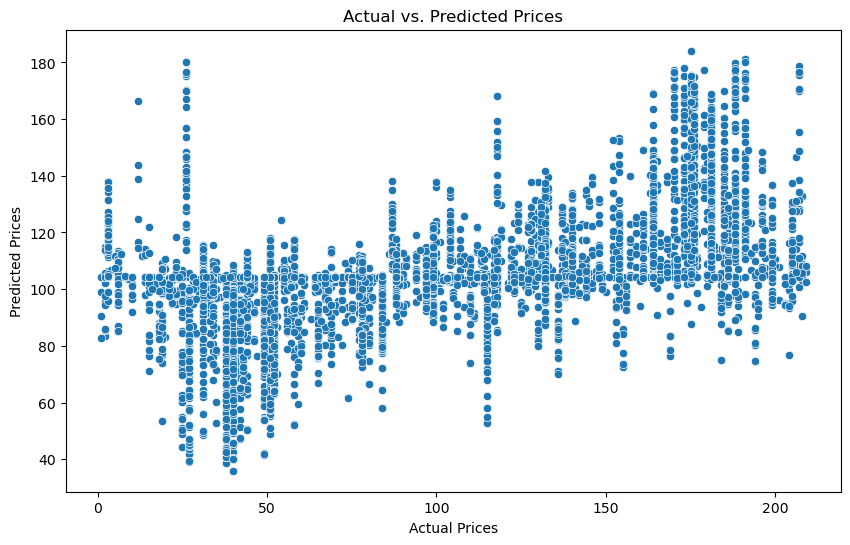

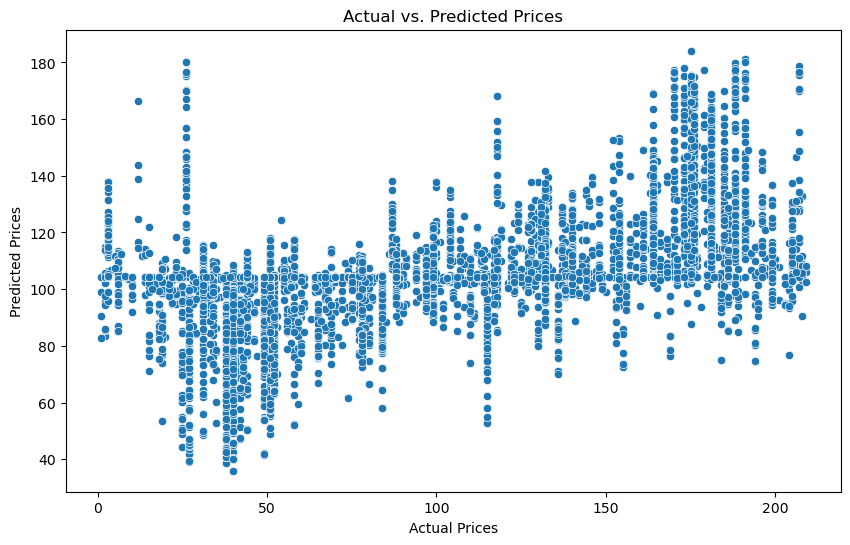

In [150]:
# Create a DataFrame for visualization
visualization_data = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_test_pred})

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual Prices', y='Predicted Prices', data=visualization_data)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()


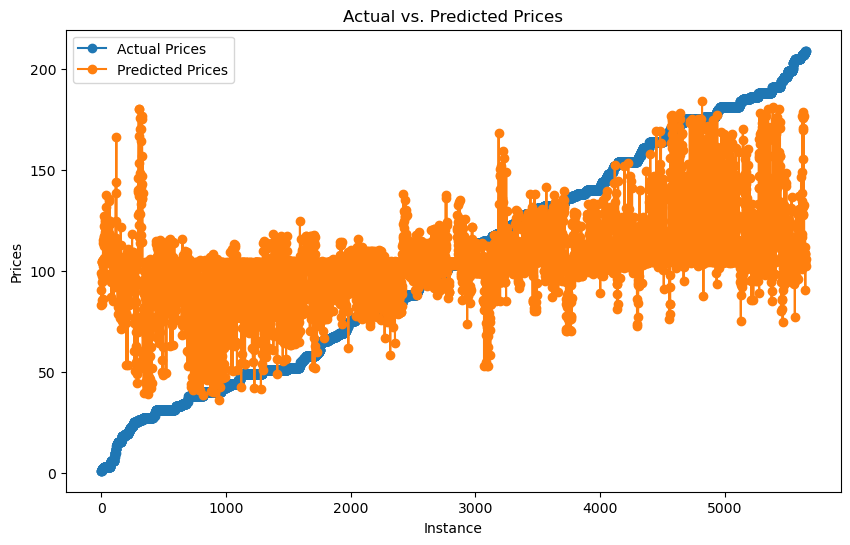

In [151]:
# Sort the indices for better visualization
sorted_indices = y_test.argsort()

# Sort the actual and predicted prices based on indices
sorted_actual_prices = y_test.iloc[sorted_indices]
sorted_predicted_prices = pd.Series(y_test_pred).iloc[sorted_indices]

# Plot the actual prices
plt.figure(figsize=(10, 6))
plt.plot(sorted_actual_prices.values, label='Actual Prices', marker='o')

# Plot the predicted prices
plt.plot(sorted_predicted_prices.values, label='Predicted Prices', marker='o')

# Customize the plot
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Instance')
plt.ylabel('Prices')
plt.legend()
plt.show()


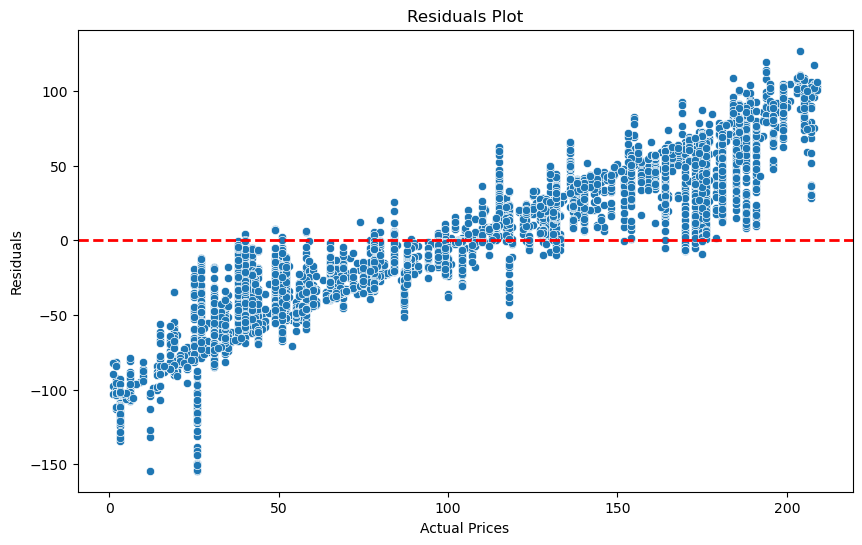

In [152]:
# Calculate residuals
residuals = y_test - y_test_pred

# Residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals Plot')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.show()
